<a href="https://colab.research.google.com/github/Dhaneesh02/Project_1/blob/unaugmented/Unaugmented_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pickle
import numpy as np

from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder

### Warning ###
import warnings
warnings.filterwarnings('ignore') ``

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = pickle.load(open('drive/My Drive/FYP/Pickle/unaugmented_[RAVDESS][MEL_SPECT][X_train].p', 'rb'))
y_train = pickle.load(open('drive/My Drive/FYP/Pickle/unaugmented_[RAVDESS][MEL_SPECT][y_train].p', 'rb'))
y_test = pickle.load(open('drive/My Drive/FYP/Pickle/unaugmented_[RAVDESS][MEL_SPECT][y_test].p', 'rb'))
X_test = pickle.load(open('drive/My Drive/FYP/Pickle/unaugmented_[RAVDESS][MEL_SPECT][X_test].p', 'rb'))

In [ ]:
print("Data without augmentation: ")
print("X_train : ",len(X_train))
print("X_test  : ",len(X_test))
print("Total audio files: ",len(X_train)+len(X_test))

Data without augmentation: 
X_train :  1075
X_test  :  269
Total audio files:  1344


In [ ]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = np_utils.to_categorical(lb.transform(np.ravel(y_test)))

In [ ]:
# Reshape for convolution
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , X_test.shape[2], X_test.shape[3], 1)

In [ ]:
X_train.shape[1:]

(5, 128, 128, 1)

In [ ]:
K.clear_session()

input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                      
                               
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_MELSPECT (InputLayer)  [(None, 5, 128, 128, 1)]  0        
                                                                 
 Conv_1_MELSPECT (TimeDistri  (None, 5, 128, 128, 64)  640       
 buted)                                                          
                                                                 
 BatchNorm_1_MELSPECT (TimeD  (None, 5, 128, 128, 64)  256       
 istributed)                                                     
                                                                 
 Activ_1_MELSPECT (TimeDistr  (None, 5, 128, 128, 64)  0         
 ibuted)                                                         
                                                                 
 MaxPool_1_MELSPECT (TimeDis  (None, 5, 64, 64, 64)    0         
 tributed)                                                   

In [ ]:
# Compile model
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('CNN_LSTM_Model.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=100, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save,tf.keras.callbacks.CSVLogger('drive/My Drive/FYP/Pickle/unaugmented_history.csv')])

Epoch 1/100
17/17 [==============================] - 18s 856ms/step - loss: 0.8444 - accuracy: 0.6707 - val_loss: 2.3409 - val_accuracy: 0.3717
Epoch 2/100
17/17 [==============================] - 14s 822ms/step - loss: 0.8761 - accuracy: 0.6651 - val_loss: 3.6591 - val_accuracy: 0.1784
Epoch 3/100
17/17 [==============================] - 14s 799ms/step - loss: 0.8481 - accuracy: 0.6847 - val_loss: 2.6601 - val_accuracy: 0.3346
Epoch 4/100
17/17 [==============================] - 14s 804ms/step - loss: 0.8507 - accuracy: 0.6753 - val_loss: 2.1004 - val_accuracy: 0.4461
Epoch 5/100
17/17 [==============================] - 14s 800ms/step - loss: 0.8154 - accuracy: 0.6716 - val_loss: 1.9401 - val_accuracy: 0.4015
Epoch 6/100
17/17 [==============================] - 14s 798ms/step - loss: 0.8516 - accuracy: 0.6735 - val_loss: 2.5627 - val_accuracy: 0.3717
Epoch 7/100
17/17 [==============================] - 14s 799ms/step - loss: 0.8704 - accuracy: 0.6651 - val_loss: 2.9254 - val_accuracy:

In [ ]:
# model.history.__dict__

In [ ]:
model.save('drive/My Drive/FYP/Pickle/unaugmented[CNN-LSTM]M.h5')
model.save_weights('drive/My Drive/FYP/Pickle/unaugmented[CNN-LSTM]W.h5')

In [ ]:
# loss, acc = new_model.evaluate(x_test, y_test, verbose=0)
# print(f"test accuracy {acc*100}")

Text(0, 0.5, 'Accuracy')

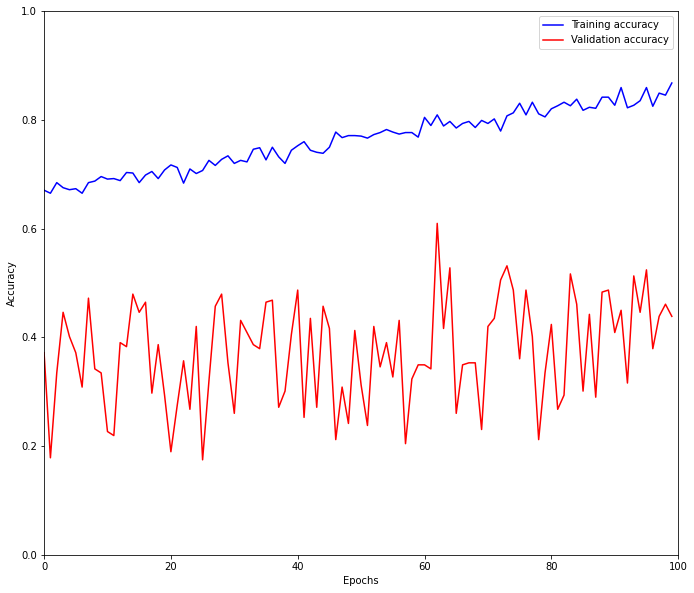

In [ ]:
# import pandas
# history = {} 
# history["history"] = pandas.read_csv('/content/drive/MyDrive/FYP/Pickle/unaugmented_history.csv')
# history["history"].head()
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
# plt.plot(history['history']['accuracy'],'-b')
# plt.plot(history['history']['val_accuracy'],'r')
plt.plot(history.history['accuracy'],'-b')
plt.plot(history.history['val_accuracy'],'r')
plt.legend(['Training accuracy','Validation accuracy'])
plt.axis([0, 100, 0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')



In [ ]:
augmented_model = tf.keras.models.load_model('/content/drive/MyDrive/Pickle/[CNN-LSTM]M.h5')


{'_activity_regularizer': None,
 '_auto_track_sub_layers': True,
 '_autocast': False,
 '_base_model_initialized': True,
 '_build_input_shape': TensorShape([None, 5, 128, 128, 1]),
 '_callable_losses': [],
 '_cluster_coordinator': None,
 '_compiled_trainable_state': <WeakKeyDictionary at 0x7fb18f721a90>,
 '_compute_dtype_object': tf.float32,
 '_compute_output_and_mask_jointly': True,
 '_default_training_arg': None,
 '_distribution_strategy': None,
 '_dtype_policy': <Policy "float32">,
 '_dynamic': False,
 '_enable_dict_to_input_mapping': True,
 '_expects_mask_arg': True,
 '_expects_training_arg': True,
 '_feed_input_names': ['Input_MELSPECT'],
 '_feed_input_shapes': [(None, 5, 128, 128, 1)],
 '_feed_inputs': [<KerasTensor: shape=(None, 5, 128, 128, 1) dtype=float32 (created by layer 'Input_MELSPECT')>],
 '_inbound_nodes_value': [],
 '_initial_weights': None,
 '_input_coordinates': [(<keras.engine.input_layer.InputLayer at 0x7fb18e4e6190>,
   0,
   0)],
 '_input_layers': [<keras.engine.i

In [ ]:
y_pred=augmented_model.predict(X_test)

In [ ]:
# unaugmented_model.load_weights('/content/drive/MyDrive/Pickle/unaugmented[CNN-LSTM]M.h5')
# unaugmented_model.__dict__

In [ ]:
import seaborn as sns

ValueError: ignored

In [ ]:
y_test

array(['DIS', 'FEA', 'ANG', 'SAD', 'DIS', 'HAP', 'SAD', 'FEA', 'ANG',
       'FEA', 'SAD', 'SAD', 'NEU', 'SAD', 'SUR', 'NEU', 'SAD', 'FEA',
       'FEA', 'SAD', 'DIS', 'DIS', 'DIS', 'SAD', 'NEU', 'ANG', 'DIS',
       'HAP', 'NEU', 'SUR', 'SUR', 'ANG', 'SUR', 'FEA', 'SAD', 'DIS',
       'SAD', 'ANG', 'SAD', 'DIS', 'ANG', 'DIS', 'DIS', 'SAD', 'FEA',
       'SAD', 'SAD', 'FEA', 'NEU', 'SAD', 'FEA', 'ANG', 'SUR', 'HAP',
       'SAD', 'SAD', 'DIS', 'DIS', 'SAD', 'HAP', 'FEA', 'NEU', 'ANG',
       'FEA', 'FEA', 'FEA', 'HAP', 'FEA', 'SUR', 'ANG', 'NEU', 'HAP',
       'ANG', 'HAP', 'SAD', 'DIS', 'FEA', 'HAP', 'DIS', 'SUR', 'SUR',
       'HAP', 'SAD', 'FEA', 'FEA', 'NEU', 'ANG', 'HAP', 'FEA', 'DIS',
       'DIS', 'HAP', 'FEA', 'NEU', 'SAD', 'ANG', 'SUR', 'ANG', 'SUR',
       'SUR', 'SAD', 'HAP', 'ANG', 'SAD', 'ANG', 'DIS', 'SUR', 'ANG',
       'DIS', 'FEA', 'ANG', 'SUR', 'FEA', 'SAD', 'FEA', 'ANG', 'HAP',
       'FEA', 'HAP', 'ANG', 'SUR', 'HAP', 'FEA', 'SAD', 'ANG', 'DIS',
       'FEA', 'NEU',

In [ ]:
y_pred.shape

(269, 7)

In [ ]:
y_test.shape

(269,)

In [ ]:

y_classes = y_pred.argmax(axis=-1)
y_classes.shape

(269,)

In [ ]:
my_dict={0:'NEU',1:'HAP',2:'SAD',3:'ANG',4:'FEA',5:'DIS',6:'SUR'}
b=np.vectorize(my_dict.get)(y_classes)
b

array(['NEU', 'SAD', 'NEU', 'DIS', 'HAP', 'ANG', 'DIS', 'ANG', 'ANG',
       'ANG', 'DIS', 'ANG', 'FEA', 'FEA', 'SUR', 'FEA', 'ANG', 'ANG',
       'ANG', 'ANG', 'HAP', 'HAP', 'HAP', 'ANG', 'FEA', 'NEU', 'HAP',
       'ANG', 'FEA', 'ANG', 'ANG', 'NEU', 'SUR', 'ANG', 'NEU', 'HAP',
       'DIS', 'NEU', 'ANG', 'HAP', 'NEU', 'HAP', 'HAP', 'ANG', 'ANG',
       'FEA', 'ANG', 'ANG', 'FEA', 'DIS', 'SAD', 'NEU', 'SUR', 'ANG',
       'ANG', 'ANG', 'HAP', 'ANG', 'DIS', 'ANG', 'ANG', 'FEA', 'NEU',
       'ANG', 'SAD', 'ANG', 'ANG', 'ANG', 'SUR', 'NEU', 'FEA', 'ANG',
       'NEU', 'ANG', 'FEA', 'HAP', 'SAD', 'ANG', 'HAP', 'SUR', 'SUR',
       'ANG', 'ANG', 'ANG', 'ANG', 'FEA', 'NEU', 'ANG', 'ANG', 'HAP',
       'HAP', 'ANG', 'ANG', 'FEA', 'DIS', 'NEU', 'SUR', 'NEU', 'ANG',
       'SUR', 'ANG', 'ANG', 'ANG', 'ANG', 'NEU', 'HAP', 'ANG', 'NEU',
       'HAP', 'SAD', 'NEU', 'ANG', 'ANG', 'FEA', 'ANG', 'NEU', 'ANG',
       'ANG', 'ANG', 'NEU', 'SUR', 'ANG', 'ANG', 'HAP', 'NEU', 'HAP',
       'ANG', 'FEA',

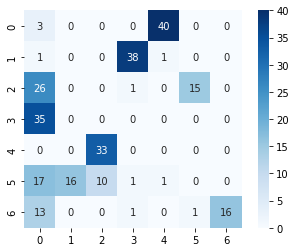

In [ ]:
from sklearn.metrics import plot_confusion_matrix
matrix_confusion = plot_confusion_matrix(y_test,b,labels=np.unique(b),display_labels=np.unique(b))
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d')

In [ ]:
np.unique(y_test)

array(['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD', 'SUR'], dtype='<U3')